In [1]:
#imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.metrics import confusion_matrix, classification_report, auc, accuracy_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
#reading the preprocessed data - (output of phase 1)
data = pd.read_csv('../data/processed/cleaned_data.csv')

In [3]:
#checking data entry upto 2022
data.tail(5)

,raceId,season,raceNumber,prixName,raceDate,driverId,constructorId,driverStartGridPos,driverFinalGridPos,driverFinalRank,driverRacePoints,driverLapCount,driverFatestLapNumber,driverFastestLapTime,driverFastestLapSpeed,constructorRacePoints,driverNumber,driverDateOfBirth,driverNationality,constructorName,constructorNationality,constructorChampionshipStandingPoints,constructorChampionshipStandingPosition,constructorChampionshipStandingWins,driverChampionshipStandingPoints,driverChampionshipStandingPosition,driverChampionshipStandingWins,circuitName,circuitLocation,circuitCountry,driverRaceResultStatus,driverName,driverAge,driverDnf,constructorDnf
6990,1096,2022,22,Abu Dhabi Grand Prix,2022-11-20,854,210,12,16.0,16,0.0,57.0,39.0,1:29.833,211.632,0.0,47.0,1999-03-22,German,Haas F1 Team,American,37.0,8.0,0.0,12.0,16.0,0.0,Yas Marina Circuit,Abu Dhabi,UAE,+1 Lap,Mick Schumacher,24.0,0,1
6991,1096,2022,22,Abu Dhabi Grand Prix,2022-11-20,825,210,16,17.0,17,0.0,57.0,40.0,1:31.158,208.556,0.0,20.0,1992-10-05,Danish,Haas F1 Team,American,37.0,8.0,0.0,25.0,13.0,0.0,Yas Marina Circuit,Abu Dhabi,UAE,+1 Lap,Kevin Magnussen,30.0,0,1
6992,1096,2022,22,Abu Dhabi Grand Prix,2022-11-20,1,131,5,18.0,18,0.0,55.0,42.0,1:29.788,211.738,10.0,44.0,1985-01-07,British,Mercedes,German,515.0,3.0,1.0,240.0,6.0,0.0,Yas Marina Circuit,Abu Dhabi,UAE,Hydraulics,Lewis Hamilton,38.0,0,1
6993,1096,2022,22,Abu Dhabi Grand Prix,2022-11-20,849,3,20,19.0,19,0.0,55.0,45.0,1:30.309,210.517,0.0,6.0,1995-06-29,Canadian,Williams,British,8.0,10.0,0.0,2.0,20.0,0.0,Yas Marina Circuit,Abu Dhabi,UAE,Collision damage,Nicholas Latifi,28.0,0,1
6994,1096,2022,22,Abu Dhabi Grand Prix,2022-11-20,4,214,10,0.0,20,0.0,27.0,24.0,1:30.579,209.889,6.0,14.0,1981-07-29,Spanish,Renault,French,173.0,4.0,0.0,81.0,9.0,0.0,Yas Marina Circuit,Abu Dhabi,UAE,Water leak,Fernando Alonso,42.0,0,1


In [4]:
#checking all features present
data.columns

Index(['raceId', 'season', 'raceNumber', 'prixName', 'raceDate', 'driverId',
       'constructorId', 'driverStartGridPos', 'driverFinalGridPos',
       'driverFinalRank', 'driverRacePoints', 'driverLapCount',
       'driverFatestLapNumber', 'driverFastestLapTime',
       'driverFastestLapSpeed', 'constructorRacePoints', 'driverNumber',
       'driverDateOfBirth', 'driverNationality', 'constructorName',
       'constructorNationality', 'constructorChampionshipStandingPoints',
       'constructorChampionshipStandingPosition',
       'constructorChampionshipStandingWins',
       'driverChampionshipStandingPoints',
       'driverChampionshipStandingPosition', 'driverChampionshipStandingWins',
       'circuitName', 'circuitLocation', 'circuitCountry',
       'driverRaceResultStatus', 'driverName', 'driverAge', 'driverDnf',
       'constructorDnf'],
      dtype='object')

In [5]:
#selecting features depending on correlation matrix from EDA performed in Phase 1
features = ['season','driverId','constructorId', 'driverStartGridPos', 
            'driverFinalGridPos', 'driverChampionshipStandingPosition', 
            'constructorChampionshipStandingPosition']

#Dropping unnecessary features and setting target variable - driver ranking in each race
X = data[features]
y = data['driverFinalRank']

# split dataset into training(80%) and testing sets (20%) and stratifying over season
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=data['season'])

# Scale the features to ensure all features are at same scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 5, 10, 20, 50, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Define the grid search object
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search object to the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Train the classifier on the training data with the best hyperparameters
clf_best = DecisionTreeClassifier(**grid_search.best_params_)
clf_best.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = clf_best.predict(X_test_scaled)

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 20}


In [7]:
# Evaluating the accuracy of the RFC classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.8613295210864903


In [8]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results.head(25))

      Actual  Predicted
2778       5          5
3962      10         10
616        9          9
5161       7          7
1902      17         17
588        1          1
3387      12         12
2967      10         10
3612      17         17
765       14         14
412        7          7
5704      10         10
4429       5          5
5302       8          8
1746       5          5
5945      11         11
4477       9          9
5419       5          5
6177       3          3
704       17         17
696        9          9
4221      17         17
5650      16         16
382       21         20
3626       9          9


In [9]:
#Checking actual vs predicted values
not_matching = results[results['Actual'] != results['Predicted']].shape[0]
print("Number of values not matching:", not_matching)

Number of values not matching: 194


In [10]:
# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.8613295210864903


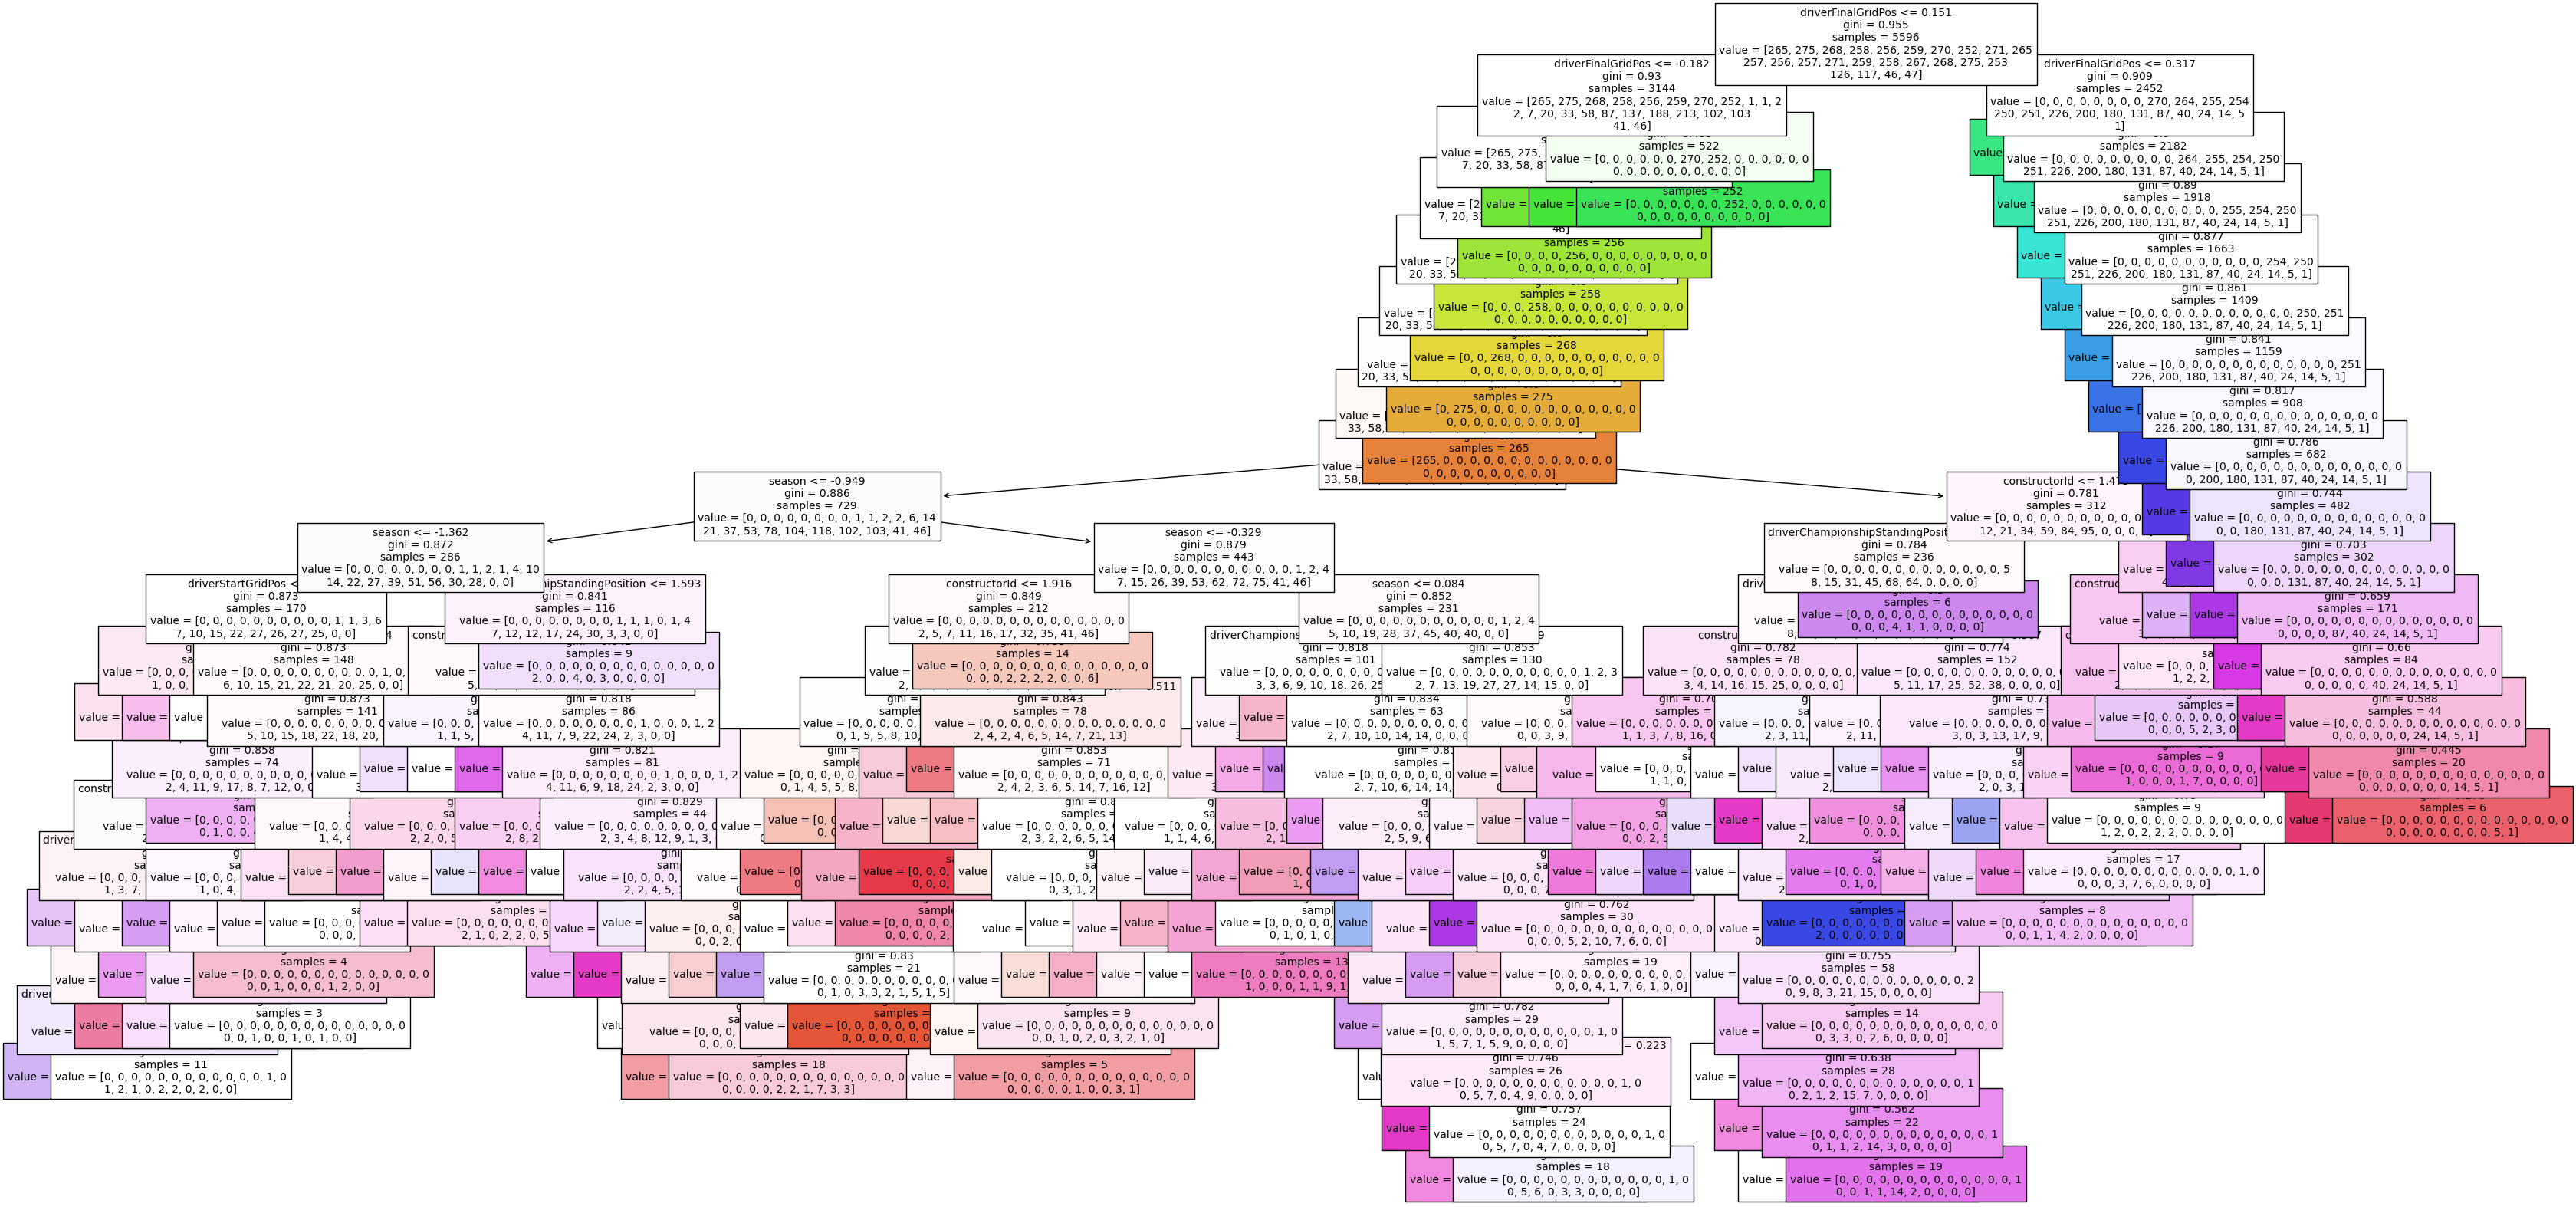

In [11]:
#plotting the decision tree
fig, ax = plt.subplots(figsize=(40, 20))
plot_tree(clf_best, feature_names=features, filled=True, fontsize=10)
plt.show()

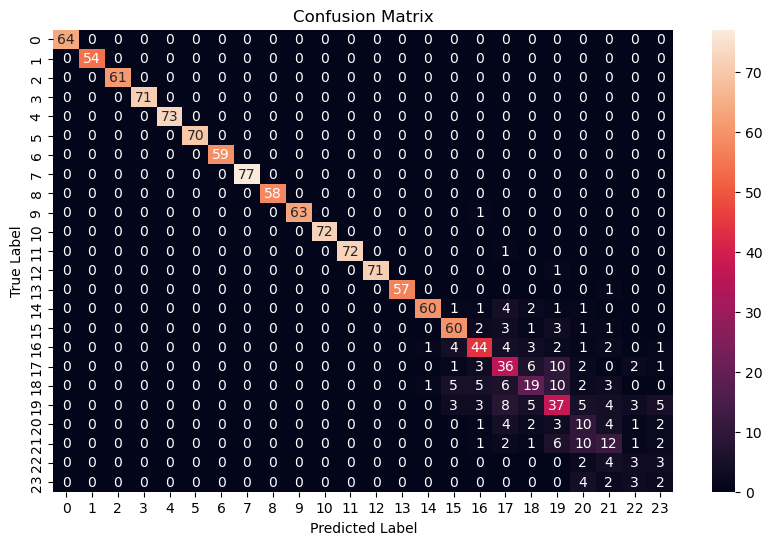

In [12]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.show()

In [13]:
# Calculate classification report
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        61
           4       1.00      1.00      1.00        71
           5       1.00      1.00      1.00        73
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        59
           8       1.00      1.00      1.00        77
           9       1.00      1.00      1.00        58
          10       1.00      0.98      0.99        64
          11       1.00      1.00      1.00        72
          12       1.00      0.99      0.99        73
          13       1.00      0.99      0.99        72
          14       1.00      0.98      0.99        58
          15       0.97      0.86      0.91        70
          16       0.81      0.85      0.83        71
          17       0.72      0.71      0.72        62
          18       0.53    

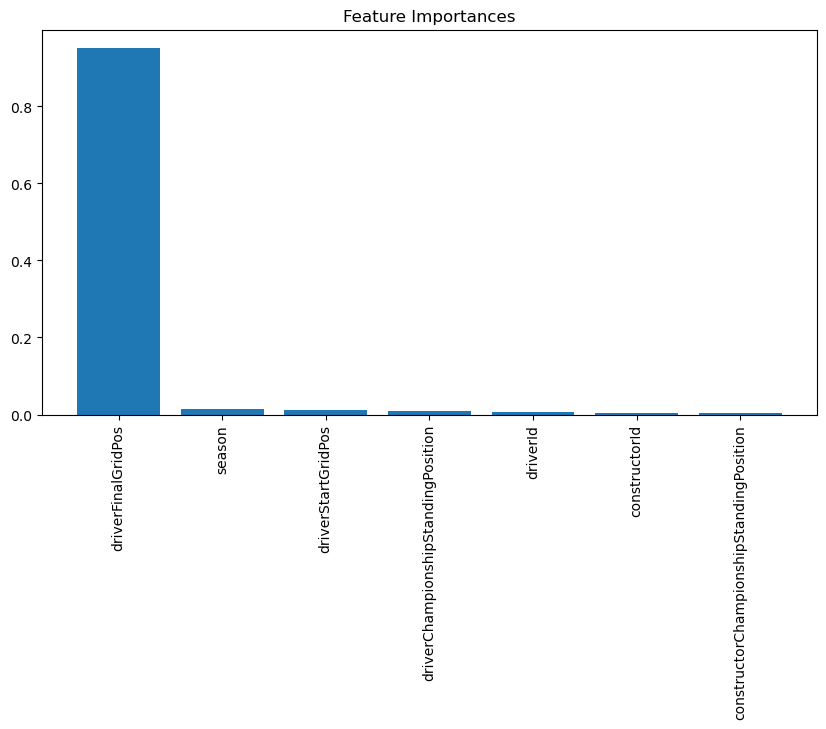

In [14]:
# Get the feature importances
importances = clf_best.feature_importances_

# Get the names of the features
feature_names = X.columns

# Sort the features by importance
indices = importances.argsort()[::-1]

# Create a bar chart of the feature importances
plt.figure(figsize=(10,5))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.title("Feature Importances")
plt.show()

In [15]:
# Convert the problem to a binary classification problem
y_train_bin = (y_train <= 3)
y_test_bin = (y_test <= 3)

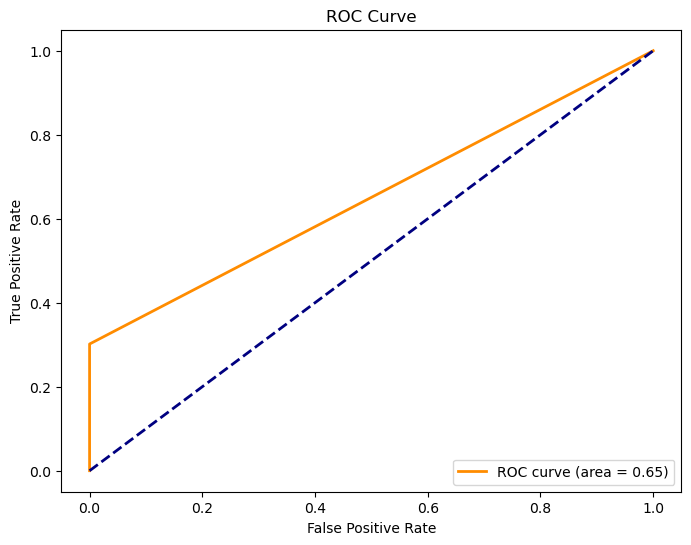

In [18]:
# Create an ROC curve
y_score = clf_best.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_bin, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

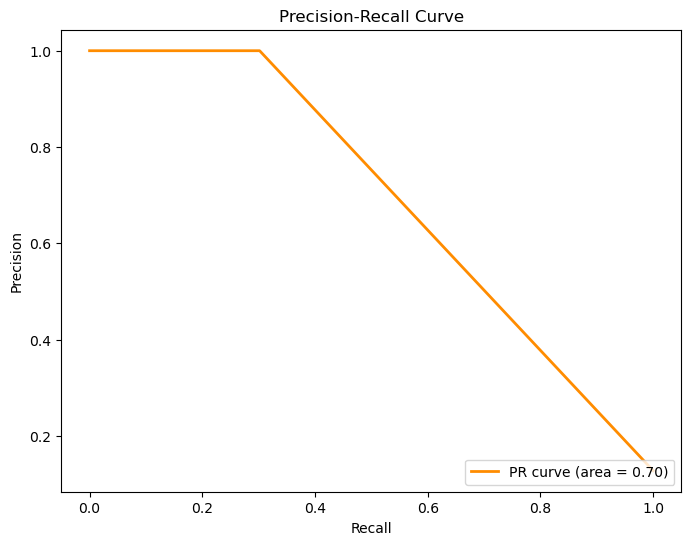

In [19]:
# Create a precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_bin, y_score)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()